<a href="https://colab.research.google.com/github/jonathanold/conflict-india/blob/main/conflict_classify_text_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify Conflict Events with BERT

I use the following pipeline to classify conflict events:
1. Load BERT model from TenserFlow Hub
2. Build BERT model by combining it with a classifier
3. Train BERT model on different variables from ACLED, fine-tuning as a part of that
4. Save model, download it.
5. Reload model to predict events from SATP.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
colab_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', colab_path)
sys.path.insert(0,colab_path)
!pip install --target=$colab_path elasticsearch

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.2/480.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 kB 23.1 MB/s eta 0:00:00


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"
!pip install -U "tf-models-official==2.13.*"

# Import other packages
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from io import StringIO
from official.nlp import optimization  # to create AdamW optimizer

import os, shutil, zipfile, requests
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import numpy as np

tf.get_logger().setLevel('ERROR')

# Define functions

1. Function to create necessary datasets
2. Function to train model
3. Function to make plots


In [ ]:
def prepare_datasets(df, label_column, description_length=10000, batch_size=32, test_size=0.2, random_state=42, max_labeled_rows=None):
    # Copy the original dataframe
    df = df.copy()

    # Truncate the description column to the specified length
    df['description'] = df['description'].astype(str).str.slice(0, description_length)

    # Specify the columns to be converted to integers
    columns_to_convert = ['source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3',
                          'riots', 'protests', 'strat_dev', 'viol_civil', 'explosions', 'battles',
                          's_violent_protest', 's_peaceful_protest', 's_mob_violence',
                          's_protest_intervention', 's_armed_clash', 's_disr_weaponuse',
                          's_attack', 's_grenade', 's_looting', 's_change_group',
                          's_sexual_violence', 's_remote_expl', 's_abduction', 's_arrest',
                          's_shelling', 's_excessive_force', 's_other', 's_agreement', 's_drone',
                          's_suicide_bomb', 's_hq_base', 's_transfer_of_territory',
                          's_gov_regains_territory']

    # Convert specified columns to integers
    df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce', downcast='integer')

    # Select and order the columns
    df = df[['id_satp_new', 'description', 'source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3',
             'riots', 'protests', 'strat_dev', 'viol_civil', 'explosions', 'battles',
             's_violent_protest', 's_peaceful_protest', 's_mob_violence',
             's_protest_intervention', 's_armed_clash', 's_disr_weaponuse',
             's_attack', 's_grenade', 's_looting', 's_change_group',
             's_sexual_violence', 's_remote_expl', 's_abduction', 's_arrest',
             's_shelling', 's_excessive_force', 's_other', 's_agreement', 's_drone',
             's_suicide_bomb', 's_hq_base', 's_transfer_of_territory',
             's_gov_regains_territory']]

    # Set the label column
    df['label'] = df[label_column]

    # Initialize counter for unique ID creation
    counter = 1

    # Function to create unique IDs
    def create_unique_id(row):
        nonlocal counter
        if pd.isnull(row['id_satp_new']):
            unique_id = f'id_a_{counter}'
            counter += 1
            return unique_id
        return row['id_satp_new']

    # Apply the function to create unique IDs
    df['id_satp_new'] = df.apply(create_unique_id, axis=1)

    # Separate labeled and unlabeled data
    labeled_df = df.dropna(subset=['label'])  # Rows where 'label' is not missing
    unlabeled_df = df[df['label'].isna()]    # Rows where 'label' is missing
    # unlabeled_df = unlabeled_df.head(100)


    # Compute class weights
    class_weights = class_weight.compute_class_weight('balanced',
                                                      classes=np.unique(labeled_df['label']),
                                                      y=labeled_df['label'].values)
    class_weight_dict = dict(enumerate(class_weights))



    # Ensure the labeled DataFrame is balanced and limited to the specified number of rows
    # min_class_count = min(labeled_df['label'].value_counts())
    # total_rows = len(labeled_df)

    # if max_labeled_rows is not None:
    #     max_per_class = min(min_class_count, max_labeled_rows // 2)
    # else:
    #    max_per_class = min(min_class_count, total_rows // 2)

    # labeled_df_class_0 = labeled_df[labeled_df['label'] == 0].sample(max_per_class, random_state=random_state)
    # labeled_df_class_1 = labeled_df[labeled_df['label'] == 1].sample(max_per_class, random_state=random_state)
    # labeled_df = pd.concat([labeled_df_class_0, labeled_df_class_1])


    # Handle missing or non-numeric values in unlabeled_df
    unlabeled_df_filled = unlabeled_df.fillna('')  # Replace NaN with empty strings

    # Split the labeled data into training and validation sets
    train_df, val_df = train_test_split(labeled_df, test_size=test_size, random_state=random_state, stratify=labeled_df['label'])

    # Helper function to convert a DataFrame to a tf.data.Dataset
    def df_to_dataset(dataframe, shuffle=True, batch_size=32):
        dataframe = dataframe.copy()
        labels = dataframe.pop('label')
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        return ds

    # Create datasets
    train_ds = df_to_dataset(train_df, batch_size=batch_size)
    val_ds = df_to_dataset(val_df, shuffle=False, batch_size=batch_size)

    # Helper function to convert a DataFrame to a tf.data.Dataset without labels
    def df_to_dataset_no_labels(dataframe, batch_size=32):
        dataframe = dataframe.copy()
        # Convert all columns to string type to avoid mixed types
        dataframe = dataframe.astype(str)
        ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
        ds = ds.batch(batch_size)
        return ds

    # Create the dataset for the unlabeled data
    test_ds = df_to_dataset_no_labels(unlabeled_df_filled, batch_size=batch_size)

    return train_ds, val_ds, test_ds, unlabeled_df_filled, class_weight_dict

In [ ]:
  def init_model(stringlength=256):
    # 1. Pre-processing model
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess, arguments={'seq_length': stringlength})

    # 2. Using the BERT model
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

    # 3. Define model
    def build_classifier_model():
      text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='description')
      preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
      encoder_inputs = preprocessing_layer(text_input)
      encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
      outputs = encoder(encoder_inputs)
      net = outputs['pooled_output']
      net = tf.keras.layers.Dropout(0.1)(net)
      net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
      return tf.keras.Model(text_input, net)

    classifier_model = build_classifier_model()

      # Show model structure
    tf.keras.utils.plot_model(classifier_model)

    # 4. Model training and optimizer
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    return bert_preprocess_model, bert_model, classifier_model, loss, metrics



In [ ]:
loss = 1
metrics = 2
classifier_model=3
class_weight_dict=4
def train_model(model, train_ds, val_ds, epochs=5, init_lr=3e-5, optimizer_type='adamw', loss=loss, metrics=metrics, classifer_model=classifier_model, class_weight_dict = class_weight_dict):
    # 4. Model training and optimizer
    num_train_steps = len(train_ds)
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type=optimizer_type)

    # 5. Load full model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    # 6. Train model
    print(f'Training model with {tfhub_handle_encoder}')
    history = classifier_model.fit(x=train_ds,
                                  validation_data=val_ds,
                                  epochs=epochs,
                                  class_weight=class_weight_dict)
    return classifier_model, history

In [ ]:
# Function to make a plot
def make_plot(history, label_column, df):
  history_dict = history.history
  print(history_dict.keys())

  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  fig = plt.figure(figsize=(10, 6))
  fig.tight_layout()

  plt.subplot(2, 1, 1)
  # r is for "solid red line"
  plt.plot(epochs, loss, 'tab:blue', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'tab:orange', label='Validation loss')
  plt.title(f'Training and validation loss, predicting {label_column}')
  # plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'tab:blue', label='Training acc')
  plt.plot(epochs, val_acc, 'tab:orange', label='Validation acc')
  plt.title(f'Training and validation accuracy, predicting {label_column}')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.tight_layout()  # Ensure tight layout after adding subplots
  plt.savefig(f'train_valid_plot_{label_column}.pdf', format='pdf')



  # Ensure the label_predicted column is loaded correctly
  predicted_labels = df[f'{label_column}']

  # Plot the histogram
  plt.figure(figsize=(10, 6))
  plt.hist(predicted_labels, bins=30, edgecolor='black')
  plt.title(f'Distribution of Predicted Labels for {label_column}')
  plt.xlabel('Predicted Label')
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.tight_layout()  # Ensure tight layout after adding subplots
  plt.savefig(f'predictions_distributions_{label_column}.pdf', format='pdf')
  files.download(f'train_valid_plot_{label_column}.pdf')
  files.download(f'predictions_distributions_{label_column}.pdf')




def save_model(classifier_model, history, var):
  dataset_name = f'acled_{var}'
  saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

  classifier_model.save(saved_model_path, include_optimizer=False)

  # Zip the saved model directory
  shutil.make_archive(saved_model_path, 'zip', saved_model_path)
  # Download the zip file
  # files.download(saved_model_path + '.zip')



In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'Several shopkeepers were killed in a riot in Delhi.',  # Riot
    'A Naxalite cadre kidnapped five adults in a village in Bihar', # Kidnapping, violence against civilians
    'Several police officers abducted and tortured villagers who were suspected to sympathize with Naxalites' # Violence against civilians
    'Farmers protested against the farmers bill in Bangalore, leaving six people injured.', # Violent protest
    'Students protested with banners against a new law introduced by the government', # Peaceful protest
    'Interior minister Amit Shah commented on the riots in Punjab on Sunday.', # Comment - i.e., unrelated event
    'Naxalites and government troops exchanged fire across the Bihar-Jharkhand border, leaving six soldiers and several naxalites injured.', # Battles
    'Peaceful protests emerged across the country', # Peaceful protest
    'In an eruption of violence, Naxalites burnt shops and demanded more inclusion while setting government buildings on fire.', # Violent protest
    'Bananas are blue and more expensive in the winter.', # Completely unrelated 1
    'In the Bihar state elections, the communist-maoist party received a majority of votes', # Completely unrelated 1
    'The russian president visited Narendra Modi on Monday' # Unrelated political event
]


In [ ]:
# Function to get prediction into dataset


# Assuming the following imports and model loading
# from transformers import TFBertForSequenceClassification, BertTokenizer

# Example of loading a model (customize according to your setup)
# model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def get_predictions(model, unlabeled_df, df, var, batch_size=32):

  # Define a function to predict raw scores for a batch of texts
  def predict_scores(texts, model, batch_size=32):
      num_batches = (len(texts) + batch_size - 1) // batch_size  # Compute the number of batches
      all_scores = []

      for i in range(num_batches):
          batch_texts = texts[i * batch_size:(i + 1) * batch_size]
          inputs = tf.constant(batch_texts)
          results = tf.sigmoid(model(inputs))
          scores = [result.numpy().tolist() for result in results]
          all_scores.extend(scores)

      return all_scores

  # Extract the text data from unlabeled_df
  texts_to_predict = unlabeled_df['description'].tolist()  # replace 'description' with your actual column name

  # Predict the scores using the trained model in batches
  predicted_scores = predict_scores(texts_to_predict, model, batch_size)  # Adjust batch_size as needed
  predicted_scores = [score[0] for score in predicted_scores]

  # Assign the predicted scores back to the DataFrame
  unlabeled_df[f'{var}_predicted'] = predicted_scores
  df_predicted = unlabeled_df[['id_satp_new', f'{var}_predicted']]
  # Optionally, you can merge these predictions back to the original DataFrame if needed
  return df_predicted

# Select and initialize BERT model

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

**NOTE: The models in small bert will be faster. L-2_H-128_A-2 will be fastest of all. Use that one for testing, and then one of the others to get the best accuracy.**


In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-256_A-4'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Set up model
1. Pre-processing model: Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. Note: Load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Also note that I changed the maximum number of tokens to 128 to 256.

2. Load BERT model - output is pooled_output, which represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire text. For the fine-tuning you are going to use the `pooled_output` array.

3. Define model: You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.
Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.

4. Define model training and optimizer. Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function. For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101). For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

5. Load model: Using the classifier_model created earlier, can compile the model with the loss, metric and optimizer.


### Read in Dataset

In original, downloading the IMBD dataset. In our case: Reading in the csv file of labelled (and unlabelled) headlines.

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.



In [ ]:
import pandas as pd
# Download the file using wget or curl
fileId = '13cyJwh23Q0YHqbDQwBWYHBf7mioad08U'
!wget -O /content/acled_x_satp.csv 'https://drive.usercontent.google.com/download?id={fileId}&confirm=xxx'
# !curl -o /content/acled_x_satp.csv 'https://drive.usercontent.google.com/download?id={fileId}&confirm=xxx'

# Read the CSV file into a DataFrame
df_orig = pd.read_csv('/content/acled_x_satp.csv')

# Display the first few rows of the DataFrame
print(df_orig.columns)

--2024-09-02 05:20:55--  https://drive.usercontent.google.com/download?id=13cyJwh23Q0YHqbDQwBWYHBf7mioad08U&confirm=xxx
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.170.132, 2404:6800:4008:c19::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.170.132|:443... connected.
HTTP request sent, awaiting response... ^C


EmptyDataError: No columns to parse from file

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['id_satp_new', 'source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3', 'riots', 'protests', 'strat_dev', 'viol_civil', 'explosions', 'battles', 's_violent_protest', 's_peaceful_protest', 's_mob_violence', 's_protest_intervention', 's_armed_clash', 's_disr_weaponuse', 's_attack', 's_grenade', 's_looting', 's_change_group', 's_sexual_violence', 's_remote_expl', 's_abduction', 's_arrest', 's_shelling', 's_excessive_force', 's_other', 's_agreement', 's_drone', 's_suicide_bomb', 's_hq_base', 's_transfer_of_territory', 's_gov_regains_territory'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1873/1873 [==============================] - 1087s 576ms/step - loss: 0.2658 - binary_accuracy: 0.9041 - val_loss: 0.0846 - val_binary_accuracy: 0.9721
Epoch 2/5
1873/1873 [==============================] - 1064s 568ms/step - loss: 0.1237 - binary_accuracy: 0.9722 - val_loss: 0.0751 - val_binary_accuracy: 0.9774
Epoch 3/5
1873/1873 [==============================] - 1080s 576ms/step - loss: 0.0996 - binary_accuracy: 0.9800 - val_loss: 0.0855 - val_binary_accuracy: 0.9774
Epoch 4/5
1873/1873 [==============================] - 1069s 570ms/step - loss: 0.0836 - binary_accuracy: 0.9839 - val_loss: 0.0809 - val_binary_accuracy: 0.9793
Epoch 5/5
1873/1873 [==============================] - 1067s 569ms/step - loss: 0.0717 - binary_accuracy: 0.9865 - val_loss: 0.0779 - val_binary_accuracy: 0.9804
Results from the model in memory:
input: Several shopkeepers were killed in a riot in Delhi. : score: 0.999422
input: A Naxalite cadre kidnapped five adults in a village in Bihar : score: 0.001761
inp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['id_satp_new', 'source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3', 'riots', 'protests', 'strat_dev', 'viol_civil', 'explosions', 'battles', 's_violent_protest', 's_peaceful_protest', 's_mob_violence', 's_protest_intervention', 's_armed_clash', 's_disr_weaponuse', 's_attack', 's_grenade', 's_looting', 's_change_group', 's_sexual_violence', 's_remote_expl', 's_abduction', 's_arrest', 's_shelling', 's_excessive_force', 's_other', 's_agreement', 's_drone', 's_suicide_bomb', 's_hq_base', 's_transfer_of_territory', 's_gov_regains_territory'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1873/1873 [==============================] - 1061s 563ms/step - loss: 0.1699 - binary_accuracy: 0.9230 - val_loss: 0.0489 - val_binary_accuracy: 0.9844
Epoch 2/5
1873/1873 [==============================] - 1060s 566ms/step - loss: 0.0554 - binary_accuracy: 0.9861 - val_loss: 0.0457 - val_binary_accuracy: 0.9883
Epoch 3/5
1873/1873 [==============================] - 1052s 561ms/step - loss: 0.0424 - binary_accuracy: 0.9897 - val_loss: 0.0389 - val_binary_accuracy: 0.9902
Epoch 4/5
1873/1873 [==============================] - 1053s 562ms/step - loss: 0.0331 - binary_accuracy: 0.9926 - val_loss: 0.0422 - val_binary_accuracy: 0.9903
Epoch 5/5
1873/1873 [==============================] - 1050s 560ms/step - loss: 0.0264 - binary_accuracy: 0.9940 - val_loss: 0.0434 - val_binary_accuracy: 0.9900
Results from the model in memory:
input: Several shopkeepers were killed in a riot in Delhi. : score: 0.000390
input: A Naxalite cadre kidnapped five adults in a village in Bihar : score: 0.000103
inp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['id_satp_new', 'source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3', 'riots', 'protests', 'strat_dev', 'viol_civil', 'explosions', 'battles', 's_violent_protest', 's_peaceful_protest', 's_mob_violence', 's_protest_intervention', 's_armed_clash', 's_disr_weaponuse', 's_attack', 's_grenade', 's_looting', 's_change_group', 's_sexual_violence', 's_remote_expl', 's_abduction', 's_arrest', 's_shelling', 's_excessive_force', 's_other', 's_agreement', 's_drone', 's_suicide_bomb', 's_hq_base', 's_transfer_of_territory', 's_gov_regains_territory'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1873/1873 [==============================] - 1071s 569ms/step - loss: 0.8172 - binary_accuracy: 0.9713 - val_loss: 0.0164 - val_binary_accuracy: 0.9965
Epoch 2/5
1873/1873 [==============================] - 1065s 568ms/step - loss: 0.3517 - binary_accuracy: 0.9972 - val_loss: 0.0152 - val_binary_accuracy: 0.9969
Epoch 3/5
1873/1873 [==============================] - 1064s 567ms/step - loss: 0.2021 - binary_accuracy: 0.9982 - val_loss: 0.0146 - val_binary_accuracy: 0.9977
Epoch 4/5
1873/1873 [==============================] - 1061s 566ms/step - loss: 0.1474 - binary_accuracy: 0.9988 - val_loss: 0.0157 - val_binary_accuracy: 0.9977
Epoch 5/5
1873/1873 [==============================] - 1050s 560ms/step - loss: 0.0853 - binary_accuracy: 0.9993 - val_loss: 0.0158 - val_binary_accuracy: 0.9977
Results from the model in memory:
input: Several shopkeepers were killed in a riot in Delhi. : score: 0.000008
input: A Naxalite cadre kidnapped five adults in a village in Bihar : score: 0.000030
inp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['id_satp_new', 'source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3', 'riots', 'protests', 'strat_dev', 'viol_civil', 'explosions', 'battles', 's_violent_protest', 's_peaceful_protest', 's_mob_violence', 's_protest_intervention', 's_armed_clash', 's_disr_weaponuse', 's_attack', 's_grenade', 's_looting', 's_change_group', 's_sexual_violence', 's_remote_expl', 's_abduction', 's_arrest', 's_shelling', 's_excessive_force', 's_other', 's_agreement', 's_drone', 's_suicide_bomb', 's_hq_base', 's_transfer_of_territory', 's_gov_regains_territory'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1873/1873 [==============================] - 1046s 555ms/step - loss: 0.3129 - binary_accuracy: 0.9647 - val_loss: 0.0905 - val_binary_accuracy: 0.9774
Epoch 2/5
1873/1873 [==============================] - 1063s 567ms/step - loss: 0.1896 - binary_accuracy: 0.9835 - val_loss: 0.0618 - val_binary_accuracy: 0.9834
Epoch 3/5
1873/1873 [==============================] - 1081s 577ms/step - loss: 0.1505 - binary_accuracy: 0.9882 - val_loss: 0.0535 - val_binary_accuracy: 0.9852
Epoch 4/5
1873/1873 [==============================] - 1063s 567ms/step - loss: 0.1119 - binary_accuracy: 0.9914 - val_loss: 0.0686 - val_binary_accuracy: 0.9859
Epoch 5/5
1873/1873 [==============================] - 1055s 563ms/step - loss: 0.0986 - binary_accuracy: 0.9930 - val_loss: 0.0627 - val_binary_accuracy: 0.9867
Results from the model in memory:
input: Several shopkeepers were killed in a riot in Delhi. : score: 0.000543
input: A Naxalite cadre kidnapped five adults in a village in Bihar : score: 0.999568
inp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['id_satp_new', 'source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3', 'riots', 'protests', 'strat_dev', 'viol_civil', 'explosions', 'battles', 's_violent_protest', 's_peaceful_protest', 's_mob_violence', 's_protest_intervention', 's_armed_clash', 's_disr_weaponuse', 's_attack', 's_grenade', 's_looting', 's_change_group', 's_sexual_violence', 's_remote_expl', 's_abduction', 's_arrest', 's_shelling', 's_excessive_force', 's_other', 's_agreement', 's_drone', 's_suicide_bomb', 's_hq_base', 's_transfer_of_territory', 's_gov_regains_territory'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1873/1873 [==============================] - 1111s 590ms/step - loss: 0.5179 - binary_accuracy: 0.9925 - val_loss: 0.0168 - val_binary_accuracy: 0.9963
Epoch 2/5
1873/1873 [==============================] - 1080s 576ms/step - loss: 0.2021 - binary_accuracy: 0.9967 - val_loss: 0.0195 - val_binary_accuracy: 0.9957
Epoch 3/5
1873/1873 [==============================] - 1078s 575ms/step - loss: 0.1279 - binary_accuracy: 0.9980 - val_loss: 0.0124 - val_binary_accuracy: 0.9975
Epoch 4/5
1873/1873 [==============================] - 1074s 573ms/step - loss: 0.0764 - binary_accuracy: 0.9987 - val_loss: 0.0131 - val_binary_accuracy: 0.9975
Epoch 5/5
1873/1873 [==============================] - 1080s 576ms/step - loss: 0.0364 - binary_accuracy: 0.9992 - val_loss: 0.0137 - val_binary_accuracy: 0.9977
Results from the model in memory:
input: Several shopkeepers were killed in a riot in Delhi. : score: 0.000016
input: A Naxalite cadre kidnapped five adults in a village in Bihar : score: 0.000109
inp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['id_satp_new', 'source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3', 'riots', 'protests', 'strat_dev', 'viol_civil', 'explosions', 'battles', 's_violent_protest', 's_peaceful_protest', 's_mob_violence', 's_protest_intervention', 's_armed_clash', 's_disr_weaponuse', 's_attack', 's_grenade', 's_looting', 's_change_group', 's_sexual_violence', 's_remote_expl', 's_abduction', 's_arrest', 's_shelling', 's_excessive_force', 's_other', 's_agreement', 's_drone', 's_suicide_bomb', 's_hq_base', 's_transfer_of_territory', 's_gov_regains_territory'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1873/1873 [==============================] - 1095s 581ms/step - loss: 0.2641 - binary_accuracy: 0.9656 - val_loss: 0.0494 - val_binary_accuracy: 0.9862
Epoch 2/5
1873/1873 [==============================] - 1095s 584ms/step - loss: 0.1393 - binary_accuracy: 0.9911 - val_loss: 0.0277 - val_binary_accuracy: 0.9928
Epoch 3/5
1873/1873 [==============================] - 1076s 574ms/step - loss: 0.0995 - binary_accuracy: 0.9943 - val_loss: 0.0460 - val_binary_accuracy: 0.9906
Epoch 4/5
1873/1873 [==============================] - 1071s 572ms/step - loss: 0.0770 - binary_accuracy: 0.9956 - val_loss: 0.0254 - val_binary_accuracy: 0.9937
Epoch 5/5
1873/1873 [==============================] - 1070s 571ms/step - loss: 0.0600 - binary_accuracy: 0.9969 - val_loss: 0.0289 - val_binary_accuracy: 0.9934
Results from the model in memory:
input: Several shopkeepers were killed in a riot in Delhi. : score: 0.000163
input: A Naxalite cadre kidnapped five adults in a village in Bihar : score: 0.003004
inp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

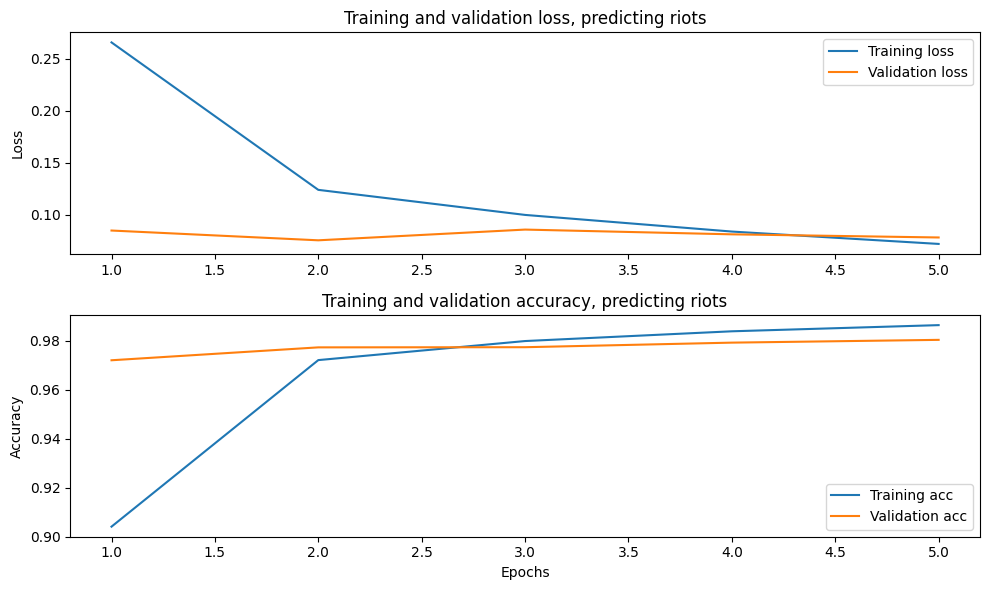

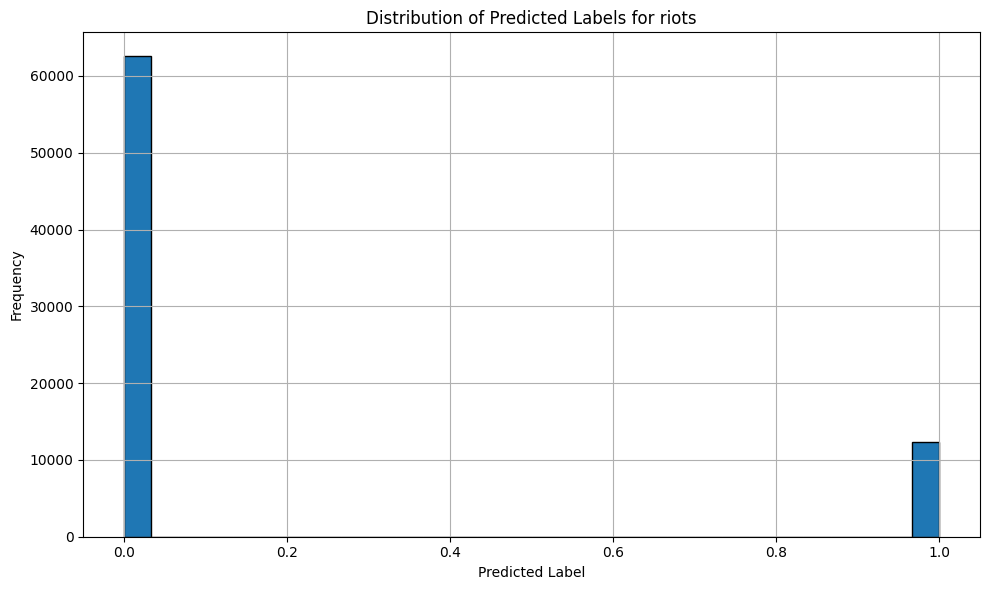

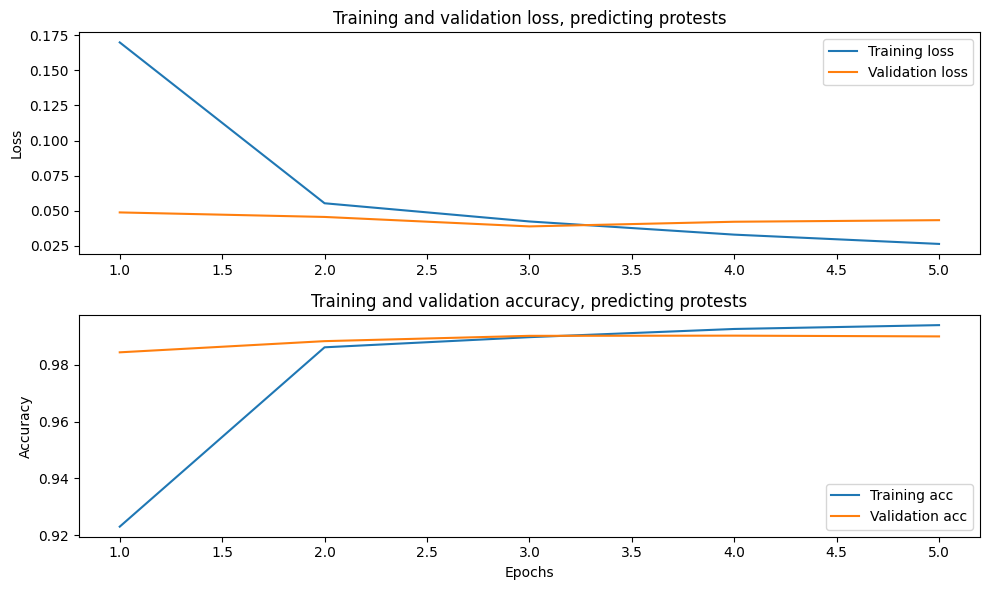

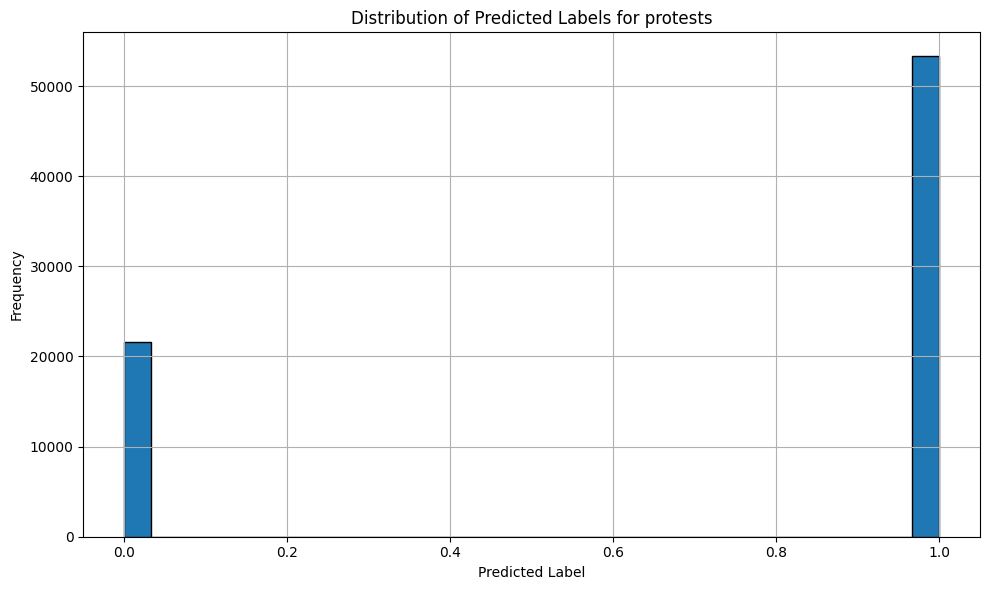

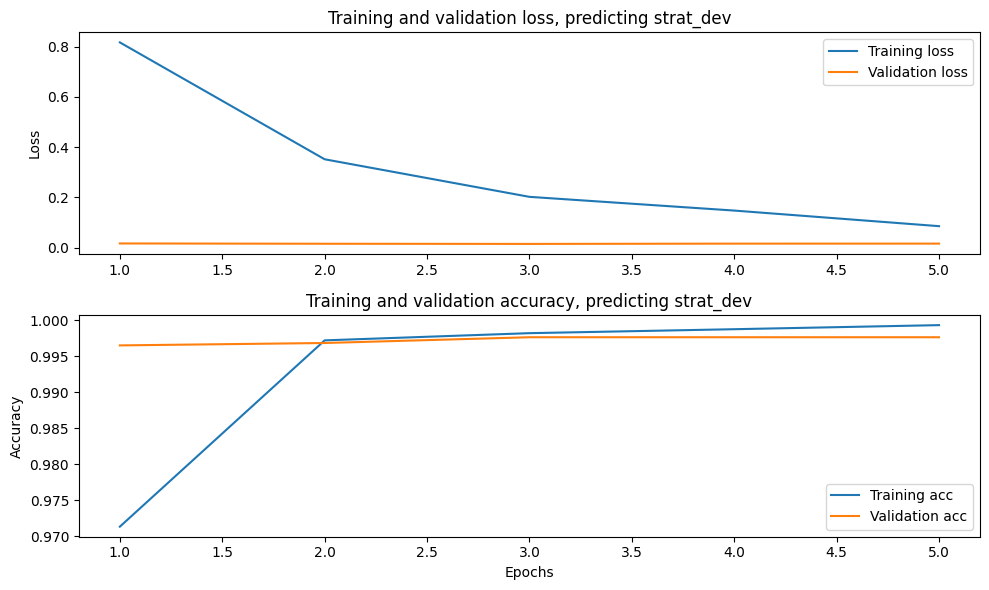

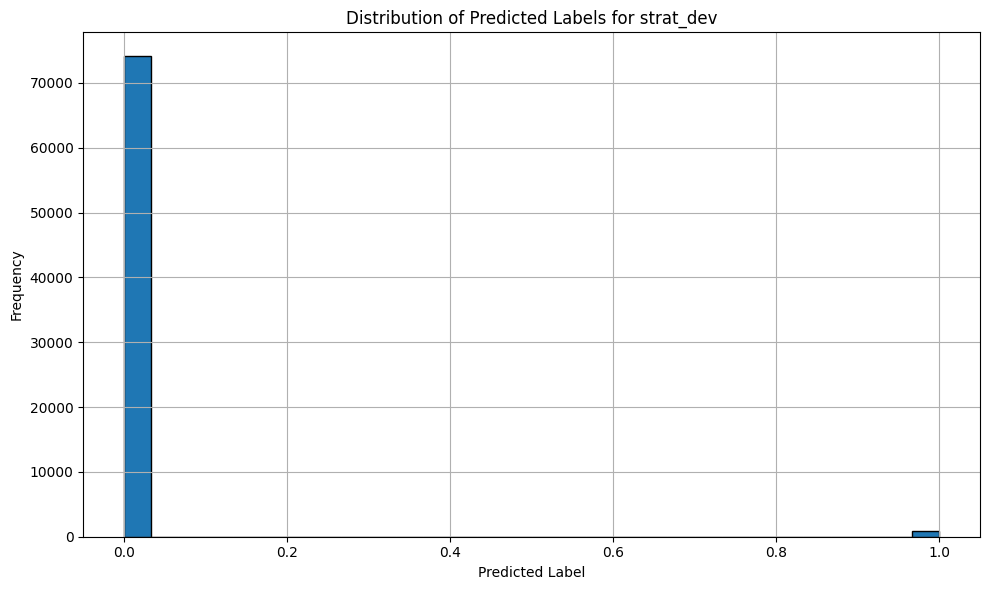

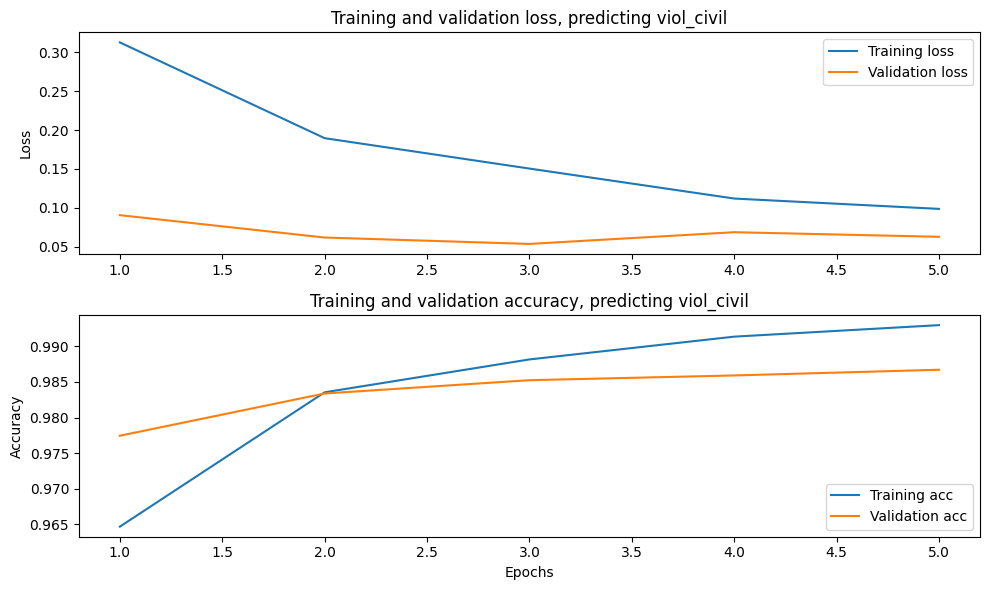

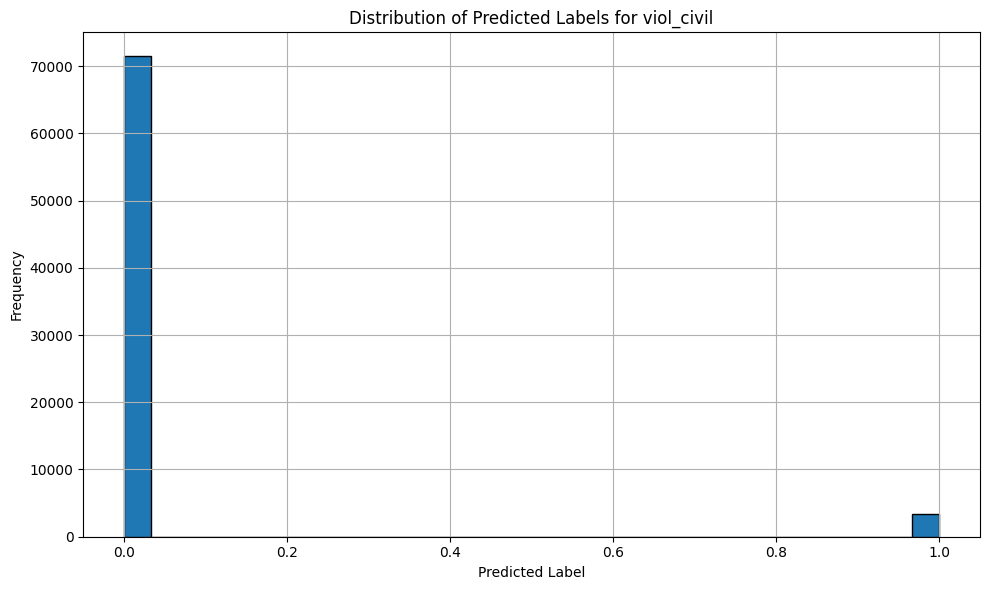

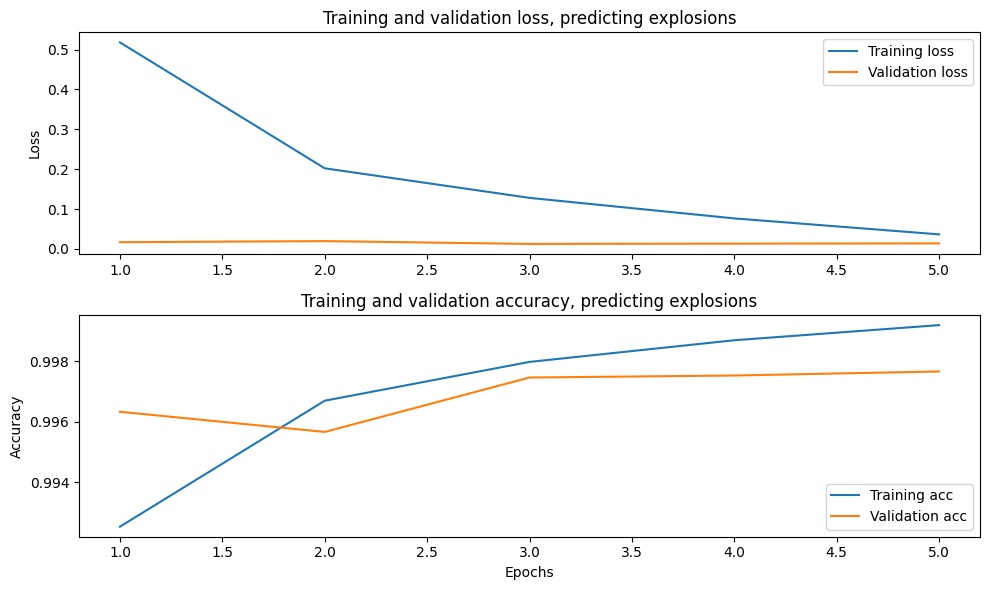

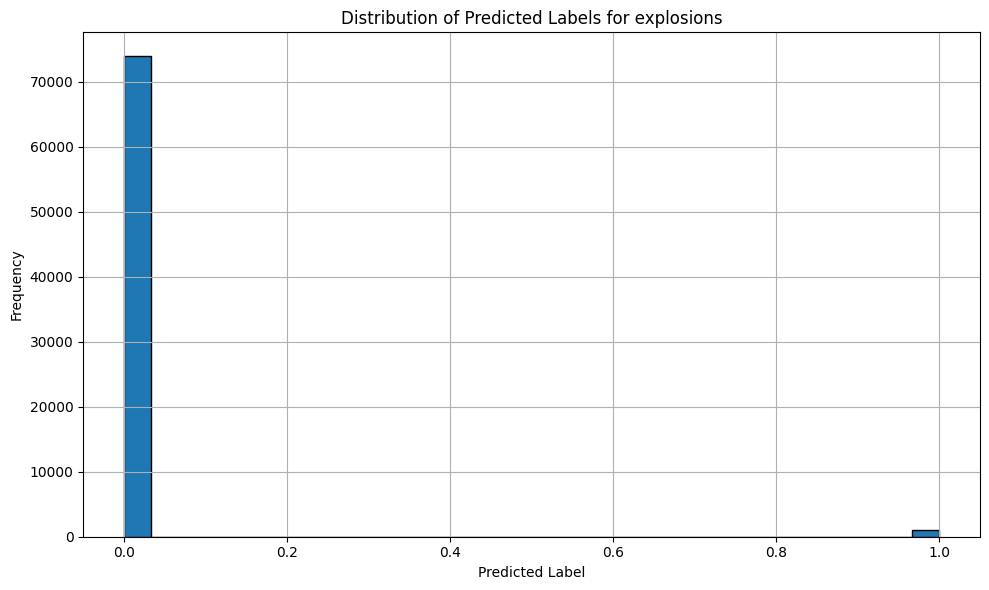

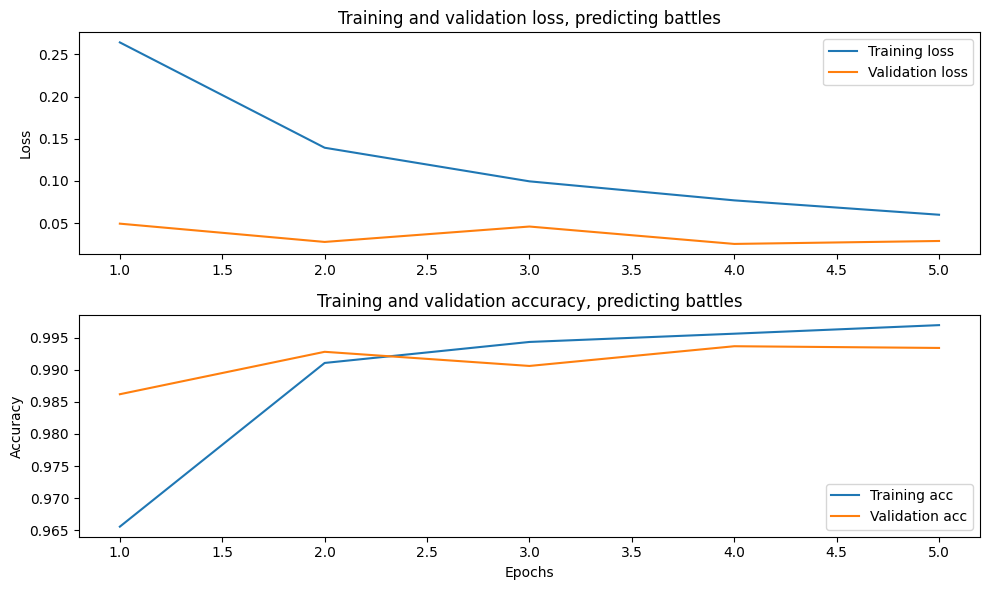

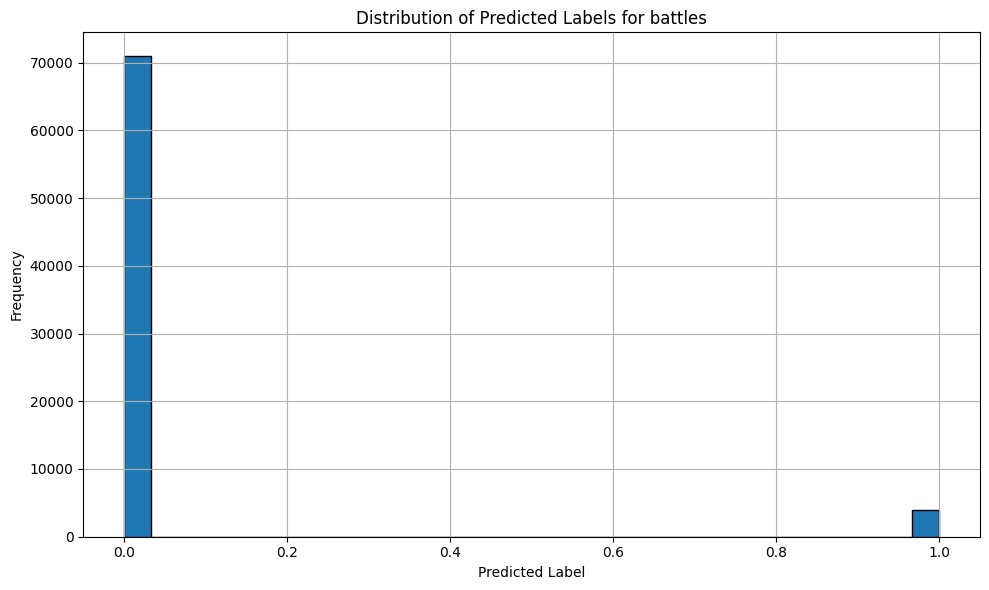

In [ ]:
varlist = ['riots', 'protests', 'strat_dev', 'viol_civil', 'explosions', 'battles']

for var in varlist:
  bert_preprocess_model, bert_model, classifier_model, loss, metrics = init_model(stringlength=256)

  train_ds, val_ds, test_ds, unlabeled_df, class_weight_dict = prepare_datasets(df_orig, var, description_length=10000, batch_size=32, test_size=0.2, random_state=42, max_labeled_rows=None)
  classifier_model, history = train_model(classifier_model, train_ds, val_ds, epochs=5, init_lr=3e-5, optimizer_type='adamw', loss=loss, metrics=metrics, classifer_model=classifier_model, class_weight_dict=class_weight_dict)

  save_model(classifier_model, history, var)

  results = tf.sigmoid(classifier_model(tf.constant(examples)))
  print('Results from the model in memory:')
  print_my_examples(examples, results)
  df_predicted = get_predictions(classifier_model, unlabeled_df=unlabeled_df, df=df_orig,  var=var, batch_size=128)
  make_plot(history=history, label_column=var, df=df_orig)

  df_predicted.to_csv(f'acled_predictions_{var}.csv', index=False)
  files.download(f'acled_predictions_{var}.csv')



Note: training time will vary depending on the complexity of the BERT model you have selected.

Let's reload the model, so you can try it side by side with the model that is still in memory.

Here you can test your model on any sentence you want, just add to the examples variable below.

In [ ]:
# from google.colab import runtime
# runtime.unassign()



In [ ]:
stop

NameError: name 'stop' is not defined

## Next steps

Reloading models from zip-files

In [ ]:
import zipfile
dataset_name = 'acled_violent_protest_bert'

zip_file_path = f'./{dataset_name}.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(f'./{dataset_name}')

# saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
reloaded_model = tf.saved_model.load(f"{dataset_name}")


'''
import zipfile

zip_file_path = './acled_peaceful_protest_bert.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('./')

import tensorflow as tf

# Path to the unzipped model directory
unzipped_model_path = './acled_peaceful_protest_bert'

# Load the model
reloaded_model = tf.saved_model.load(unzipped_model_path)
'''
